In [58]:
# dataset
FILENAME = "compounds_ms2structures"

# similarity calculation
MORGAN_RADIUS=9
FINGERPRINT_BITS=4096

# analogue selection
NUM_QUERIES = 1000
GROUP_SIZE=10
SIMILARITY_RANGE=(0.7, 0.9999)
NO_OVERLAP=False
RANDOM_SELECT = True   # Set to false to iterate through the dataset sequentially. Might be be better for high similarity selections.
SEED=42

# unsimilar query selection
MAX_SIMILARITY = 0.15

## Init

In [59]:
import os
import random
random.seed(SEED)
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import SmilesMolSupplier

from ms_chemical_space_explorer.similarity_maps import get_similarity_map_weights, FingerprintFunction

path = os.path.join( "data", "datasets", FILENAME + ".csv")
fingerprints_file = os.path.join("data", "group_similarity", f"{FILENAME}_fingerprints_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
sim_matrix_file = os.path.join("data", "group_similarity", f"{FILENAME}_ruzicka_similarities_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
df_file = os.path.join("data", "group_similarity", "benchmarks", "backup", f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

if FILENAME == "compounds_ms2structures":
    mol_supplier = SmilesMolSupplier(path, delimiter=',', titleLine=True, smilesColumn=1, nameColumn=0)
elif FILENAME == "biostructures_combined":
    mol_supplier = SmilesMolSupplier(path, titleLine=True, nameColumn=0)

# compounds = pd.read_csv(path)
# compounds.head()

## Fingerprints & Similarities

In [60]:
fingerprints = np.load(fingerprints_file, mmap_mode ='r')
sim_matrix = np.load(sim_matrix_file, mmap_mode ='r')

print(fingerprints.shape, sim_matrix.shape)

(37811, 4096) (37811, 37811)


## Load benchmark with similar groups

In [61]:
def str_to_list_of_ints(series):
    return [int(x) for x in series.strip("[]").split(",") if x.strip().isdigit()]


analogue_df = pd.read_csv(df_file, index_col=0)
analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
print(f"Found {df_file}\nLoaded {len(analogue_df)} analogue groups.")
analogue_df

Found data\group_similarity\benchmarks\backup\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Loaded 1000 analogue groups.


,analogue_ids,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights
query_id,,,,,,,,,
35713,"[23200, 15235, 23492, 16509, 788, 36440, 6612,...",0.757227,0.651649,0.718469,0.958369,7296.0,0.048941,0.495740,0.745032
6698,"[4956, 18407, 36935, 14442, 34068, 12344, 9297...",0.728808,0.741461,0.711796,0.930022,1639.0,0.034004,0.529015,0.699278
23723,"[6469, 4900, 21458, 21338, 4110, 2985, 4580, 3...",0.776946,0.714194,0.768828,0.958988,18024.0,0.019481,0.433941,0.779438
23219,"[34068, 19889, 23098, 30328, 4192, 27915, 4203...",0.764761,0.679330,0.671523,0.952904,16049.0,0.046053,0.593117,0.690729
7161,"[6420, 34482, 15048, 9393, 8816, 6018, 14039, ...",0.752489,0.651582,0.704055,0.949291,14628.0,0.032426,0.504996,0.736315
...,...,...,...,...,...,...,...,...,...
9389,"[13371, 16668, 1846, 4964, 12, 26636, 25711, 3...",0.856211,0.793353,0.725266,0.981181,29804.0,0.012239,0.555282,0.724871
34088,"[16501, 19951, 7447, 20032, 33526, 11214, 2076...",0.793224,0.726373,0.781378,0.950357,24155.0,0.017810,0.413372,0.760490
26225,"[8055, 31010, 7549, 29135, 276, 7567, 27413, 3...",0.754275,0.703045,0.700822,0.937447,17181.0,0.028164,0.524335,0.721508


## Benchmark

In [62]:
analogue_df.analogue_ids[35713]

[23200, 15235, 23492, 16509, 788, 36440, 6612, 29122, 12150, 18256]

In [63]:
def pick_unsimilar_query(group_ids, sim_matrix, max_similarity_threshold):
    sims =[]
    used_queries = []
    
    query_id = random.randint(0, len(sim_matrix) - 1)
    found_unsimilar_query = False
    while found_unsimilar_query == False:
        # pick unused query
        while query_id in used_queries:
            query_id = random.randint(0, len(sim_matrix) - 1)
        used_queries.append(query_id)
        
        # get similarities to group
        sims = []
        for group_id in group_ids:
            sims.append(sim_matrix[query_id, group_id])
        
        # check if query is unsimilar enough
        if np.max(sims) < max_similarity_threshold:
            break
    
    return query_id, sims

In [64]:
def get_unsimilar_benchmark(df_file, analogue_df, sim_matrix, mol_supplier, morgan_radius, fpSize,  max_similarity_threshold):
    try:
        print(f"Trying to load benchmark dataframe from {df_file}")
        analogue_df = pd.read_csv(df_file, index_col=0)
        analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nTrying to access benchmark columns.\nExisting columns: {analogue_df.columns.tolist()}")
        query_sim_unsimilar= analogue_df[:1].query_sim_unsimilar
        sgs_score_unsimilar=analogue_df[:1].sgs_score_unsimilar
        print(f"Benchmark found! Loaded benchmark for {len(analogue_df)} queries.")
    except Exception as e:
        print(f"Benchmark not found: {df_file}\nRunning the benchmark dataframe generation.")
        # generate benchmark dataframe
        fp_function = FingerprintFunction(fingerprint="MORGAN")
        fp_function.fp_type = "count"
        fp_function.morgan_radius = morgan_radius
        fp_function.nbits = fpSize

        for query_id, row in tqdm(analogue_df.iterrows(), desc="Processing queries", total=len(analogue_df)):
            analogue_ids = [int(x) for x in row["analogue_ids"]]
            query_id_unsimilar, query_sims_unsimilar = pick_unsimilar_query(analogue_ids, sim_matrix, max_similarity_threshold)
            analogue_df.loc[query_id, 'query_id_unsimilar'] = query_id_unsimilar
            analogue_df.loc[query_id, 'query_sim_unsimilar'] = np.mean(query_sims_unsimilar)

            query = mol_supplier[query_id_unsimilar]
            
            # query_sims = []
            stacked_mean_weights = []
            query_scaled_inverted_differnces = []
            for ref_id in tqdm(analogue_ids, desc=f"Processing analogues for query {query_id_unsimilar}", leave=False):
                # # gather ruzicka similarity of analogue vs query
                # query_sims.append(sim_matrix[query_id_unsimilar][ref_id])
                
                # generate the reference molecule
                ref_analogue = mol_supplier[ref_id]
                
                # create array for stacked weights
                stacked_atomic_weights = [0] * ref_analogue.GetNumAtoms()
                
                # compute the group similarity map weights
                for probe_id in analogue_ids:#tqdm(analogue_ids, desc=f"Computing weights for weights for analogue {ref_id}", leave=False):
                    if ref_id == probe_id:
                        continue
                    
                    probe_analogue = mol_supplier[probe_id]

                    # extract and standardize similarity weights for the reference molecule
                    ref_sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(probe_analogue, ref_analogue, fp_function.get_function, metric=DataStructs.TanimotoSimilarity) #this is the bottle neck
                    #print(f"Getting weights took {(pd.Timestamp.now() - getting_weights_start).total_seconds():.4f} seconds")

                    # stack the weights
                    stacked_atomic_weights = [stacked_atomic_weights[i] + ref_sim_weights[i] for i in range(ref_analogue.GetNumAtoms())]
                # Standardize the stacked weights
                stacked_atomic_weights, _ = SimilarityMaps.GetStandardizedWeights(stacked_atomic_weights)
                stacked_mean_weights.append(sum(stacked_atomic_weights) / len(stacked_atomic_weights))
                
                # compute the similarity map weights against the query molecule
                query_atomic_weights = get_similarity_map_weights(ref_analogue, query, fp_function)
                
                # calculate absolute weight difference for each atom against the query
                query_abs_differences = ([abs(stacked_atomic_weights[i] - query_atomic_weights[i]) for i in range(len(stacked_atomic_weights))])
                query_mean_difference = sum(query_abs_differences) / len(query_abs_differences)
                
                # scale and invert the mean absolute difference to get a similarity score
                query_scaled_inverted_differnce = 1 - (query_mean_difference * 0.5)
                query_scaled_inverted_differnces.append(query_scaled_inverted_differnce)
            # --- gather all similarity metrics ---
            # # mean ruzicka similarity of analogue vs query ruzicka similaities
            # analogue_df.loc[query_id, "query_sim"] = np.mean(query_sims)
            
            # # mean of all-vs-all analogue ruzicka similarities
            # fp_group_sim_matrix = ruzicka_similarity_matrix(fingerprints[analogue_ids], fingerprints[analogue_ids])
            # group_sim = off_diagonal_mean(fp_group_sim_matrix)
            # analogue_df.loc[query_id, "group_sim"] = group_sim
            
            # # mean of the means of stacked atomic weights of all-vs-all analogue similarity maps
            # unscaled_sgs = np.mean(stacked_mean_weights)                # range [-1, 1]
            # analogue_df.loc[query_id, "sgs"] = (unscaled_sgs + 1) / 2   # range [0, 1]
            
            # scaled and inverted mean of the means of the absolute differences between atomic stacked weights and atomic query weights
            sgs_score = (sum(query_scaled_inverted_differnces) / len(query_scaled_inverted_differnces))
            analogue_df.loc[query_id, "sgs_score_unsimilar"] = sgs_score

        analogue_df.to_csv(df_file)
        print(f"Saved {len(analogue_df)} queries to {df_file}.")
    return analogue_df

In [65]:
analogue_df = get_unsimilar_benchmark(df_file, analogue_df, sim_matrix, mol_supplier, MORGAN_RADIUS, FINGERPRINT_BITS, MAX_SIMILARITY)

Trying to load benchmark dataframe from data\group_similarity\benchmarks\backup\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Found data\group_similarity\benchmarks\backup\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['analogue_ids', 'query_sim', 'group_sim', 'sgs', 'sgs_score', 'query_id_unsimilar', 'query_sim_unsimilar', 'sgs_score_unsimilar', 'query_mean_weights']
Benchmark found! Loaded benchmark for 1000 queries.


In [66]:
dissim_file = os.path.join("data", "group_similarity", "benchmarks", "backup", f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

dissim_df = pd.read_csv(dissim_file, index_col=0)
dissim_df["analogue_ids"] = dissim_df["analogue_ids"].apply(str_to_list_of_ints)

In [67]:
dissim_df

,analogue_ids,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights
query_id,,,,,,,,,
35713,"[23200, 15235, 23492, 16509, 788, 36440, 6612,...",0.757227,0.651649,0.718469,0.958369,7296.0,0.048941,0.495740,0.745032
6698,"[4956, 18407, 36935, 14442, 34068, 12344, 9297...",0.728808,0.741461,0.711796,0.930022,1639.0,0.034004,0.529015,0.699278
23723,"[6469, 4900, 21458, 21338, 4110, 2985, 4580, 3...",0.776946,0.714194,0.768828,0.958988,18024.0,0.019481,0.433941,0.779438
23219,"[34068, 19889, 23098, 30328, 4192, 27915, 4203...",0.764761,0.679330,0.671523,0.952904,16049.0,0.046053,0.593117,0.690729
7161,"[6420, 34482, 15048, 9393, 8816, 6018, 14039, ...",0.752489,0.651582,0.704055,0.949291,14628.0,0.032426,0.504996,0.736315
...,...,...,...,...,...,...,...,...,...
9389,"[13371, 16668, 1846, 4964, 12, 26636, 25711, 3...",0.856211,0.793353,0.725266,0.981181,29804.0,0.012239,0.555282,0.724871
34088,"[16501, 19951, 7447, 20032, 33526, 11214, 2076...",0.793224,0.726373,0.781378,0.950357,24155.0,0.017810,0.413372,0.760490
26225,"[8055, 31010, 7549, 29135, 276, 7567, 27413, 3...",0.754275,0.703045,0.700822,0.937447,17181.0,0.028164,0.524335,0.721508


In [68]:
analogue_df = pd.read_csv(df_file, index_col=0)
analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)

In [69]:
analogue_df

,analogue_ids,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights
query_id,,,,,,,,,
35713,"[23200, 15235, 23492, 16509, 788, 36440, 6612,...",0.757227,0.651649,0.718469,0.958369,7296.0,0.048941,0.495740,0.745032
6698,"[4956, 18407, 36935, 14442, 34068, 12344, 9297...",0.728808,0.741461,0.711796,0.930022,1639.0,0.034004,0.529015,0.699278
23723,"[6469, 4900, 21458, 21338, 4110, 2985, 4580, 3...",0.776946,0.714194,0.768828,0.958988,18024.0,0.019481,0.433941,0.779438
23219,"[34068, 19889, 23098, 30328, 4192, 27915, 4203...",0.764761,0.679330,0.671523,0.952904,16049.0,0.046053,0.593117,0.690729
7161,"[6420, 34482, 15048, 9393, 8816, 6018, 14039, ...",0.752489,0.651582,0.704055,0.949291,14628.0,0.032426,0.504996,0.736315
...,...,...,...,...,...,...,...,...,...
9389,"[13371, 16668, 1846, 4964, 12, 26636, 25711, 3...",0.856211,0.793353,0.725266,0.981181,29804.0,0.012239,0.555282,0.724871
34088,"[16501, 19951, 7447, 20032, 33526, 11214, 2076...",0.793224,0.726373,0.781378,0.950357,24155.0,0.017810,0.413372,0.760490
26225,"[8055, 31010, 7549, 29135, 276, 7567, 27413, 3...",0.754275,0.703045,0.700822,0.937447,17181.0,0.028164,0.524335,0.721508


In [70]:
analogue_df.drop(columns=["analogue_ids"])

,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights
query_id,,,,,,,,
35713,0.757227,0.651649,0.718469,0.958369,7296.0,0.048941,0.495740,0.745032
6698,0.728808,0.741461,0.711796,0.930022,1639.0,0.034004,0.529015,0.699278
23723,0.776946,0.714194,0.768828,0.958988,18024.0,0.019481,0.433941,0.779438
23219,0.764761,0.679330,0.671523,0.952904,16049.0,0.046053,0.593117,0.690729
7161,0.752489,0.651582,0.704055,0.949291,14628.0,0.032426,0.504996,0.736315
...,...,...,...,...,...,...,...,...
9389,0.856211,0.793353,0.725266,0.981181,29804.0,0.012239,0.555282,0.724871
34088,0.793224,0.726373,0.781378,0.950357,24155.0,0.017810,0.413372,0.760490
26225,0.754275,0.703045,0.700822,0.937447,17181.0,0.028164,0.524335,0.721508


In [71]:
dissim_df.drop(columns=["analogue_ids", "query_id_unsimilar", "query_sim_unsimilar", "sgs_score_unsimilar"])

,query_sim,group_sim,sgs,sgs_score,query_mean_weights
query_id,,,,,
35713,0.757227,0.651649,0.718469,0.958369,0.745032
6698,0.728808,0.741461,0.711796,0.930022,0.699278
23723,0.776946,0.714194,0.768828,0.958988,0.779438
23219,0.764761,0.679330,0.671523,0.952904,0.690729
7161,0.752489,0.651582,0.704055,0.949291,0.736315
...,...,...,...,...,...
9389,0.856211,0.793353,0.725266,0.981181,0.724871
34088,0.793224,0.726373,0.781378,0.950357,0.760490
26225,0.754275,0.703045,0.700822,0.937447,0.721508


In [72]:
analogue_df.describe()

,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.784824,0.735464,0.738398,0.957548,18985.421000,0.033895,0.491314,0.745276
std,0.031377,0.045664,0.031290,0.015605,10818.095266,0.022050,0.056313,0.035400
min,0.716962,0.623999,0.619026,0.896554,26.000000,0.000000,0.378090,0.613402
25%,0.761932,0.701849,0.720571,0.948777,9729.750000,0.020092,0.452948,0.724587
50%,0.781721,0.731256,0.735877,0.957966,18532.000000,0.029506,0.484230,0.746556
75%,0.803512,0.766433,0.760394,0.966872,28568.750000,0.040616,0.519336,0.768106
max,0.876133,0.903892,0.816185,0.996199,37787.000000,0.136147,0.790356,0.852296


In [73]:
analogue_df["group_sim_diff"] = abs(analogue_df.sgs - analogue_df.group_sim)
analogue_df.sort_values("group_sim_diff", ascending=False).head()

,analogue_ids,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights,group_sim_diff
query_id,,,,,,,,,,
3216,"[9181, 9674, 36397, 35699, 25548, 35992, 2274,...",0.804509,0.854252,0.708190,0.954570,2614.0,0.015589,0.545747,0.753140,0.146062
24553,"[16190, 25409, 3971, 12810, 18801, 28459, 1971...",0.761172,0.903892,0.758152,0.904190,26941.0,0.018620,0.478906,0.769042,0.145741
12883,"[28047, 1578, 35992, 5671, 9674, 36834, 23223,...",0.780408,0.847155,0.702260,0.936931,9656.0,0.017227,0.559828,0.764880,0.144895
9674,"[26823, 25294, 34429, 5671, 36834, 20237, 2274...",0.796600,0.829740,0.695041,0.939938,16457.0,0.032031,0.563804,0.754618,0.134699
28047,"[12883, 9181, 3856, 13876, 17007, 5671, 11227,...",0.805326,0.837420,0.703989,0.952716,1280.0,0.027907,0.541478,0.750402,0.133431


In [74]:
analogue_df[analogue_df.group_sim_diff > 0.05].describe()

,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights,group_sim_diff
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.790169,0.741133,0.743093,0.956302,18520.779070,0.033906,0.489930,0.748682,0.072095
std,0.034318,0.062306,0.030853,0.014821,10731.944944,0.022893,0.058825,0.038915,0.018532
min,0.727803,0.623999,0.619026,0.904190,26.000000,0.000000,0.378090,0.613402,0.050268
25%,0.764472,0.687916,0.723959,0.948419,9524.750000,0.018870,0.448333,0.726637,0.057782
50%,0.786558,0.730073,0.742727,0.958812,17625.500000,0.028855,0.485965,0.752948,0.067833
75%,0.808622,0.792811,0.765460,0.966023,27820.500000,0.040490,0.522793,0.773852,0.081193
max,0.876133,0.903892,0.815544,0.991309,37787.000000,0.136147,0.790356,0.852296,0.146062


In [75]:
xmin = min(analogue_df.sgs.min(), analogue_df.group_sim.min())
xmax = max(analogue_df.sgs.max(), analogue_df.group_sim.max())

<Axes: >

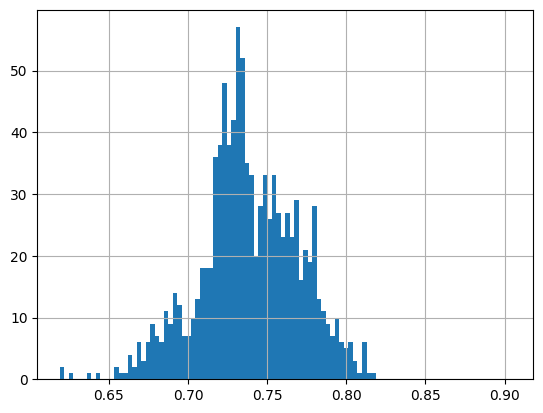

In [76]:
analogue_df.sgs.hist(bins=100, range=(xmin, xmax))

<Axes: >

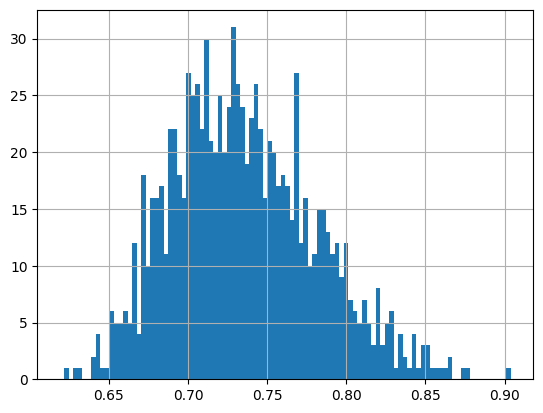

In [77]:
analogue_df.group_sim.hist(bins=100, range=(xmin, xmax))

In [78]:
analogue_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 35713 to 26268
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   analogue_ids         1000 non-null   object 
 1   query_sim            1000 non-null   float64
 2   group_sim            1000 non-null   float64
 3   sgs                  1000 non-null   float64
 4   sgs_score            1000 non-null   float64
 5   query_id_unsimilar   1000 non-null   float64
 6   query_sim_unsimilar  1000 non-null   float64
 7   sgs_score_unsimilar  1000 non-null   float64
 8   query_mean_weights   1000 non-null   float64
 9   group_sim_diff       1000 non-null   float64
dtypes: float64(9), object(1)
memory usage: 85.9+ KB


In [79]:
analogue_df.describe()

,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights,group_sim_diff
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.784824,0.735464,0.738398,0.957548,18985.421000,0.033895,0.491314,0.745276,0.041276
std,0.031377,0.045664,0.031290,0.015605,10818.095266,0.022050,0.056313,0.035400,0.027683
min,0.716962,0.623999,0.619026,0.896554,26.000000,0.000000,0.378090,0.613402,0.000038
25%,0.761932,0.701849,0.720571,0.948777,9729.750000,0.020092,0.452948,0.724587,0.018202
50%,0.781721,0.731256,0.735877,0.957966,18532.000000,0.029506,0.484230,0.746556,0.038753
75%,0.803512,0.766433,0.760394,0.966872,28568.750000,0.040616,0.519336,0.768106,0.058064
max,0.876133,0.903892,0.816185,0.996199,37787.000000,0.136147,0.790356,0.852296,0.146062


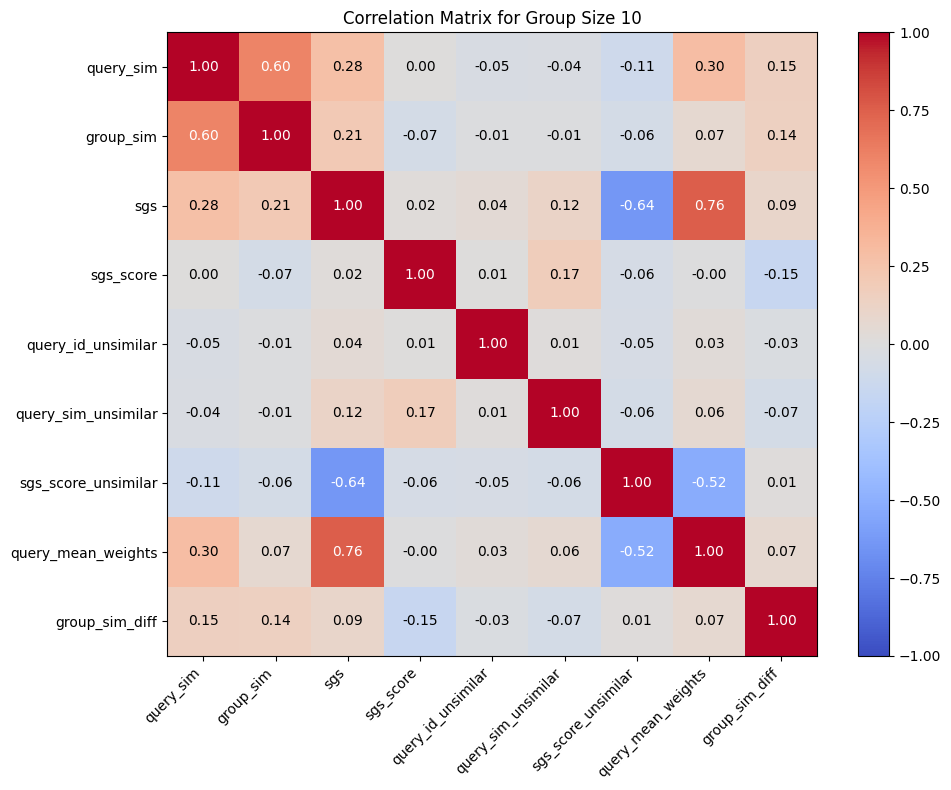

In [81]:
import matplotlib.pyplot as plt

# Create correlation matrix heatmap without seaborn
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = analogue_df.drop(columns=["analogue_ids"]).corr()

# Create heatmap using matplotlib
im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Add colorbar
plt.colorbar(im)

# Set ticks and labels
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.index)

# Add correlation values as text
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.5 else "white")

plt.title(f"Correlation Matrix for Group Size {df_id + 2}")
plt.tight_layout()
plt.show()